In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize & reshape
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add random noise
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


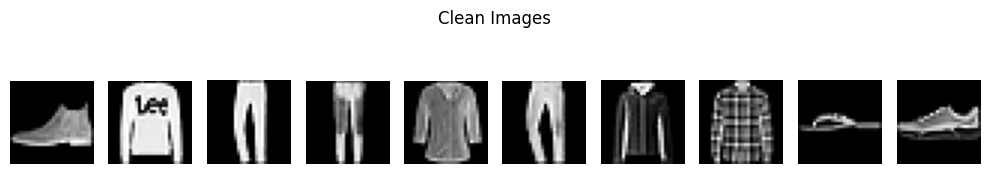

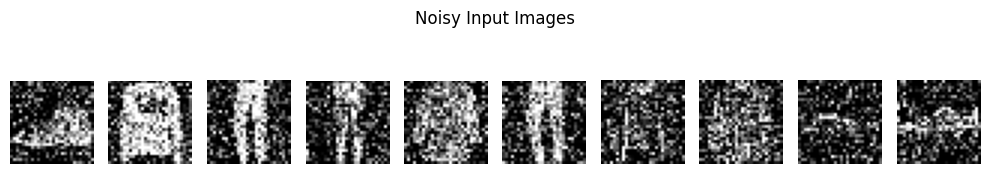

In [10]:
# 4. Visualize Clean and Noisy Images
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Clean Images")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Noisy Input Images")
plt.tight_layout()
plt.show()


In [11]:
# Encoder
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name="bottleneck")(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (MaxPooling2D)            │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=[early_stop])


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - loss: 0.4087 - val_loss: 0.3072
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.3035 - val_loss: 0.3010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.2980 - val_loss: 0.2980
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.2956 - val_loss: 0.2964
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.2934 - val_loss: 0.2949
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.2933 - val_loss: 0.2938
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.2916 - val_loss: 0.2931
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.2902 - val_loss: 0.2918
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.2888 - val_loss: 0.2912
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.2888 - val_loss: 0.2906
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.2885 - val_loss: 0.2898
Epoch 12/50
469/469 ━━━━━━━━━━

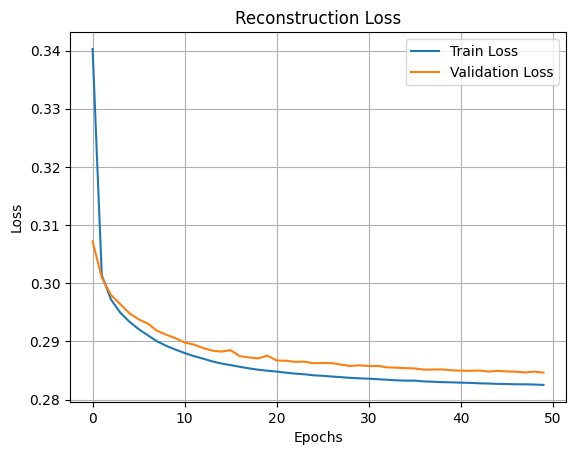

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
  encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)
encoded_imgs = encoder.predict(x_test_noisy[:10])

print("Encoded Shape:", encoded_imgs.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Encoded Shape: (10, 7, 7, 16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


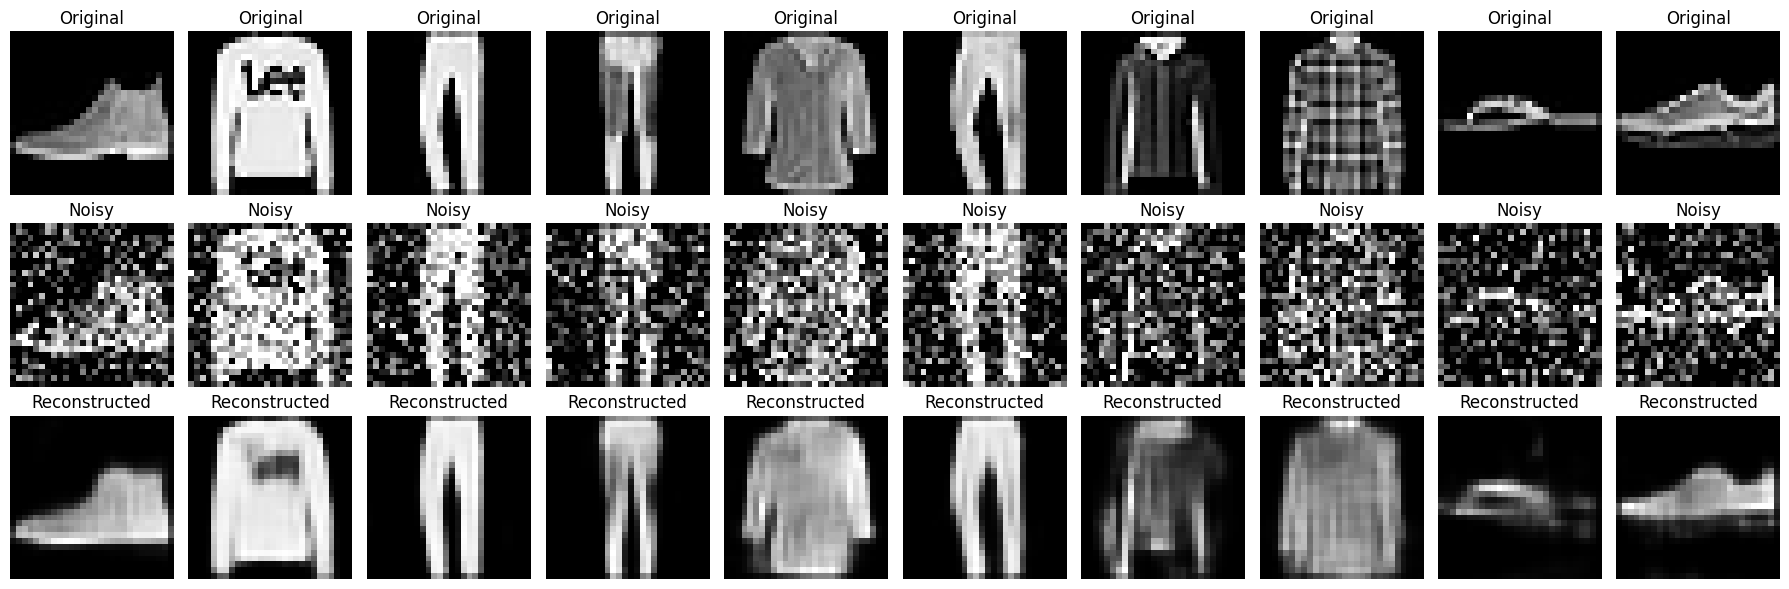

In [15]:
decoded_imgs = autoencoder.predict(x_test_noisy[:10])

n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


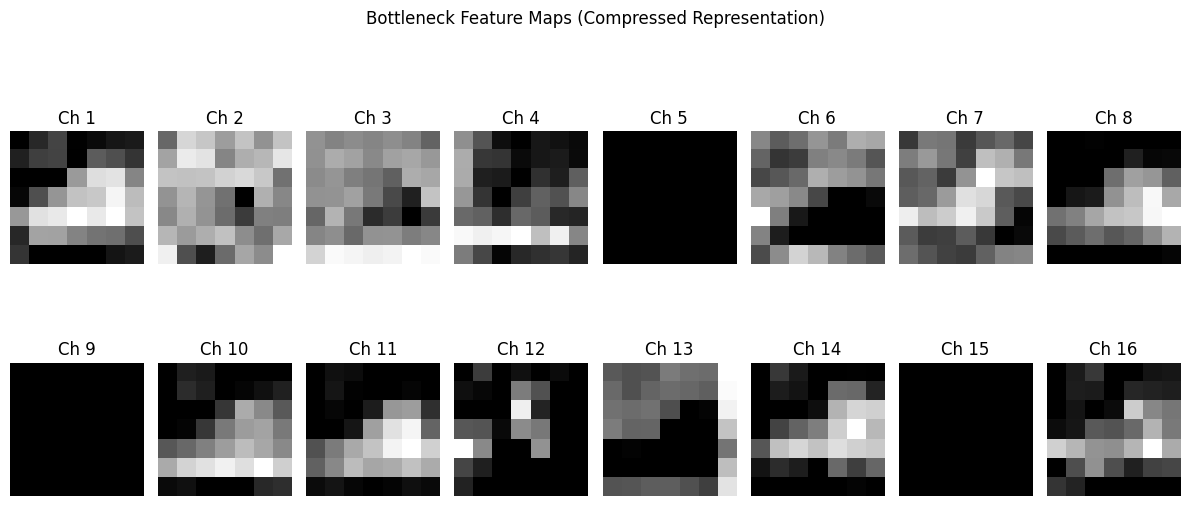

In [16]:
# --- Bottleneck Visualization ---
encoder = tf.keras.Model(inputs=autoencoder.input,
                         outputs=autoencoder.get_layer("bottleneck").output)

# Get bottleneck output for one noisy image
bottleneck_output = encoder.predict(x_test_noisy[:1])  # shape: (1, 7, 7, 16)

# Visualize the 16 feature maps in the bottleneck output
plt.figure(figsize=(12, 6))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(bottleneck_output[0, :, :, i], cmap='gray')
    plt.title(f'Ch {i+1}')
    plt.axis("off")
plt.suptitle("Bottleneck Feature Maps (Compressed Representation)")
plt.tight_layout()
plt.show()



   
   
  __Analysis of Denoising Autoencoder Using Convolutional Layers on Fashion MNIST__

__Objective:__

-> Denoise Fashion MNIST images by learning compressed representations.

-> Reconstruct clean images from noisy inputs.

-> Visualize the learning process through loss graphs, intermediate features (bottleneck), and output reconstructions.

__Dataset Description:__

-> Fashion MNIST dataset with 28x28 grayscale images representing clothing items.

-> Used only the image data (labels ignored for unsupervised learning).

-> Total of 60,000 training and 10,000 testing images.

__Preprocessing Steps:__

Normalization: Pixel values scaled to the [0, 1] range.

Reshaping: Each image reshaped to (28, 28, 1) to fit the Conv2D input format.

Noise Addition: Gaussian noise (mean=0, std=1, scale=0.4) added to training and testing images to simulate corrupted input.

Clipping: Noisy images clipped to keep pixel values in valid range [0, 1].

 __Model Architecture: Convolutional Autoencoder__

__Encoder:__
-> Uses two Conv2D + MaxPooling2D layers.

-> Output of shape (7, 7, 16) from the bottleneck.

-> Captures essential patterns and reduces spatial dimensions.

__Decoder:__
-> Mirrors the encoder with upsampling instead of pooling.

-> Final output shape matches the original input: (28, 28, 1).

__Loss Graph:__

The training and validation loss decreased steadily.

Early stopping prevented overfitting and ensured best model retention.

__Visual Results:__

🔹 Clean vs Noisy vs Reconstructed Images
Top Row: Clean test images

Middle Row: Corresponding noisy input

Bottom Row: Autoencoder output (denoised)

Observation: The reconstructed images resemble the originals closely, proving the model’s ability to remove noise and retain details.